In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class JacksCarRentalEnvironment:
    
    TRANSFER_COST = 2
    RENTAL_INCOME = 10
    MAX_CAPACITY = 20
    REQUEST_RATE = (3,4)
    RETURN_RATE = (3,2)
    
    def __init__(self):
        self._carparkA = CarPark(3,3,type(self).MAX_CAPACITY)
        self._carparkB = CarPark(4,2,type(self).MAX_CAPACITY)
        print([self._carparkA.getObservation(),self._carparkB.getObservation()])
        
    def reset(self,val=None):
        self._carparkA = CarPark(3,3,type(self).MAX_CAPACITY,val)
        self._carparkB = CarPark(4,2,type(self).MAX_CAPACITY,val)
        print([self._carparkA.getObservation(),self._carparkB.getObservation()])
        
        
    def step(self,val):
        # val > 0 Autos wandern von A nach B
        # val < 0 Autos wandern von B nach A
        if val < 0:
            a = self._carparkB
            b = self._carparkA
            val = -1*val
        else:
            a = self._carparkA
            b = self._carparkB
        # Zu aller erst werden die autos von jack bewegt    
        # An einem Tag kommen zuerst Kunden und leihen Autos
        # Dann werden Autos zurückgegeben
        # Dann kann jack entscheiden welche autos bewegt werden
        # Einfachster Fall val == 0
        carsRented = 0
        reward = 0.0
        done = False
        if val == 0:
            carsRented += a.carsRenting()
            carsRented += b.carsRenting()
            reward = 10.0*carsRented
            # Bevor Autos kommen auf available pruefen oder spaeter
            if 0 in [self._carparkA.getObservation(),self._carparkB.getObservation()]:
                done = True
            a.carsArriving()
            b.carsArriving()
        else:
            availableCars = a.removeCars(val)
            reward = -2.0*val
            b.addCars(availableCars)
            carsRented += a.carsRenting()
            carsRented += b.carsRenting()
            reward = reward + 10.0*carsRented
            if 0 in [self._carparkA.getObservation(),self._carparkB.getObservation()]:
                done = True
            a.carsArriving()
            b.carsArriving()
        observation = [self._carparkA.getObservation(),self._carparkB.getObservation()]
        return (observation,reward,done,'')
    
    
    
class CarPark:
    
    def __init__(self, lamRequest, lamReturn, maxSize,val=None):
        self._lamRequest = lamRequest
        self._lamReturn = lamReturn
        self._maxSize = maxSize
        self._maxMove = 5
        if val == None:
            self._carsAvailable = np.random.randint(0,21,1)[0]
        else:
            self._carsAvailable = val
        
        
        
    def getObservation(self):
        return self._carsAvailable
    
    def carsArriving(self):
        r = np.random.poisson(self._lamReturn)
        if self._carsAvailable + r > self._maxSize:
            self._carsAvailable = self._maxSize
        else:
            self._carsAvailable += r
    
    def carsRenting(self):
        carsRented = np.random.poisson(self._lamRequest)
        if self._carsAvailable - carsRented < 0:
            carsRented = self._carsAvailable
            self._carsAvailable = 0
        else:
            self._carsAvailable -= carsRented
        return carsRented
           
    def addCars(self,amount):
        if amount > self._maxMove:
            raise Exception('Zu viele Autos')
        elif amount < 0:
            raise Exception('Du wolltest autos hinzufuegen')
        self._carsAvailable += amount
        if self._carsAvailable > self._maxSize:
            self._carsAvailable = self._maxSize
            
    def removeCars(self,amount):
        if amount > self._maxMove:
            raise Exception('Zu viele Autos')
        elif amount < 0:
            raise Exception('Du')
        if self._carsAvailable - amount < 0:
            amount = self._carsAvailable
            self._carsAvailable = 0
        else:
            self._carsAvailable -= amount
        return amount
    
class JacksCarRentalEnvironmentModel(JacksCarRentalEnvironment):
    
    def get_transition_probabilities_and_expected_reward(self, state, action):
        """
            Compute the $p(s', r\mid s,a)$
            Parameters
            ----------
            old_state: tuple of two ints
                the state (cars_at_A, cars_at_B)
            action: int
                nigthly movements of the cars as a int between -5 to 5, e.g.: 
                action +3: move three cars from A to B. 
                action -2: move two cars from B to A.
                
            Returns
            -------
            numpy array (2d - float): mapping from (new) states to probabilities
                index first dimension: cars at A
                index second dimension: cars at B
                value: probability  
            float:  expected reward for the state-action pair
        """
        #assert type(action) == int
        assert np.abs(action) <=5
        # first we move the cars in the night
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
            
        state = self._nightly_moves(state, action)
    
        expected_reward = - type(self).TRANSFER_COST * np.abs(action)
        expected_reward += self._expected_reward_rent(state)
        
        transition_probabilities = self._rent_transition_probabilities(state)
        transition_probabilities = self._returns_transition_probabilities(transition_probabilities)
        return transition_probabilities, expected_reward  
        
        
    def _nightly_moves(self, state, action):
        
        cars_at_A = state[0]
        cars_at_B = state[1]
        if action > 0:
            cars_moved = min(action, cars_at_A)
        else:
            cars_moved = max(action, -cars_at_B)
        
        cars_at_A = min(cars_at_A - cars_moved, type(self).MAX_CAPACITY)
        cars_at_B = min(cars_at_B + cars_moved, type(self).MAX_CAPACITY)
        return [cars_at_A, cars_at_B]
        
    def _expected_reward_rent(self, state):
        expected_reward_rent = 0.
        m = type(self).MAX_CAPACITY+1
        request_mu = type(self).REQUEST_RATE
        for i in (0,1):
            cars_at_loc = state[i]
            rv = scipy.stats.poisson(request_mu[i])
            rent_prob = (rv.pmf(range(m)))
            #logger.debug(rent_prob)
            rent_prob[cars_at_loc] = rent_prob[cars_at_loc:].sum()
            rent_prob[cars_at_loc+1:] = 0. 
            #logger.debug(rent_prob)
            expected_reward_rent += np.dot(np.arange(len(rent_prob)), rent_prob) * type(self).RENTAL_INCOME
        return expected_reward_rent
        
    def _rent_transition_probabilities(self, state):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m = 15
        n = num_states_for_a_location + 2*m
        p_  = [np.zeros(n), np.zeros(n)]
        request_mu = type(self).REQUEST_RATE
        
        for i in (0,1):
            rv = scipy.stats.poisson(request_mu[i])
            cars_at_loc = state[i]
            x = cars_at_loc + m + 1     
            rent_prob = (rv.pmf(range(x)))
            assert state[i]-x+m+1 == 0
            p_[i][0:cars_at_loc+m+1] = rent_prob[::-1]
            p_[i][m] = p_[i][:m+1].sum()
            p_[i] = p_[i][m:-m]
        return p_
    
    def _returns_transition_probabilities(self, state_probalility):
        
        num_states_for_a_location = type(self).MAX_CAPACITY + 1
        m=11
        n = num_states_for_a_location + 2*m
        returns_mu = type(self).RETURN_RATE
        p_  = [np.zeros(num_states_for_a_location), np.zeros(num_states_for_a_location)]
        for i in (0,1):
            rv = scipy.stats.poisson(returns_mu[i])
            #logger.debug(len(state_probalility[i]))
            for cars_at_loc in range(len(state_probalility[i])):
                p = np.zeros(n)
                #logger.debug(p.shape)
                x = num_states_for_a_location - cars_at_loc + m - 1     
                return_prob = (rv.pmf(range(x)))
                #logger.debug (p[cars_at_loc+m:-1].shape)
                p[cars_at_loc+m:-1] = return_prob
                #logger.debug(return_prob)
                p[num_states_for_a_location+m-1] = p[num_states_for_a_location+m-1:].sum()
                p = p[m:-m]
                #logger.debug(p)
                #logger.debug(p.sum())
                p_[i] += p * state_probalility[i][cars_at_loc]
        return p_
    

In [27]:
# Die 21*21 States in einem 1d-array representieren
statesPerCarPark = 21
V = np.zeros(statesPerCarPark**2)
# Funktion die fuer carsAt_A und carsAt_B als Param, den Index in V wieder gibt
getValIndex = lambda carsAt_A,carsAt_B: carsAt_A*statesPerCarPark + carsAt_B #- 1

In [3]:
jack = JacksCarRentalEnvironmentModel()

[20, 19]


In [4]:
# Prob S Prime fuer gegeben S & A als Vektor
def getSPrimeProbs(stateIndex,action):
    statesPerCarPark = 21
    carPark_A,carPark_B = divmod(stateIndex,statesPerCarPark)
    temp, reward = jack.get_transition_probabilities_and_expected_reward((carPark_A,carPark_B),action)
    prob_A,prob_B = temp
    p_SA = np.outer(prob_A,prob_B).flatten()
    return p_SA,reward

In [120]:
P_SASp = np.zeros((statesPerCarPark**2,11,statesPerCarPark**2))
R_SA = np.zeros((statesPerCarPark**2,11))
for s in range(21*21):
    for a in range(11):
        action = a - 5
        P_SASp[s,a], R_SA[s,a] = getSPrimeProbs(s,action)

In [5]:
import datetime

In [6]:
def valueIteration(statesPerCarPark,n_action,getSPrimeProbs, gamma=0.9):
    P_SASp = np.zeros((statesPerCarPark**2,n_action,statesPerCarPark**2))
    R_SA = np.zeros((statesPerCarPark**2,n_action))
    for s in range(statesPerCarPark**2):
        for a in range(n_action):
            action = a - 5
            P_SASp[s,a], R_SA[s,a] = getSPrimeProbs(s,action)
    V = np.zeros(statesPerCarPark**2) 
    Q_SA = R_SA + np.dot(P_SASp,V)
    converged = False
    counter = 0
    bevore = datetime.datetime.now()
    while not converged:
        V = np.max(Q_SA, axis=1)
        Q_SA_new = R_SA + gamma * np.dot(P_SASp,V)
        print('Iteration ' + str(counter) + ' diff: ' + str(np.max(np.abs(np.max(Q_SA_new, axis=1)-V))))
        counter += 1
        if np.allclose(Q_SA_new,Q_SA):
            converged = True
        if counter > 50000:
            print('Not Converged')
            converged = True
        Q_SA = Q_SA_new 
    after = datetime.datetime.now()
    print(after-bevore)
    
    return Q_SA

In [7]:
Q_SA = valueIteration(21,11,getSPrimeProbs)

Iteration 0 diff: 62.9995281477
Iteration 1 diff: 56.677752603
Iteration 2 diff: 50.8633152834
Iteration 3 diff: 45.4291613785
Iteration 4 diff: 40.4097735626
Iteration 5 diff: 35.8570095549
Iteration 6 diff: 31.7503699907
Iteration 7 diff: 28.0393290215
Iteration 8 diff: 24.6886659364
Iteration 9 diff: 21.6837528311
Iteration 10 diff: 19.016856382
Iteration 11 diff: 16.6748174251
Iteration 12 diff: 14.6351465165
Iteration 13 diff: 12.8671620276
Iteration 14 diff: 11.3361528953
Iteration 15 diff: 10.0106981742
Iteration 16 diff: 8.86061084391
Iteration 17 diff: 7.85955582489
Iteration 18 diff: 6.98569286952
Iteration 19 diff: 6.22051856486
Iteration 20 diff: 5.54846400767
Iteration 21 diff: 4.95638789096
Iteration 22 diff: 4.43359005469
Iteration 23 diff: 3.97017867818
Iteration 24 diff: 3.55836347522
Iteration 25 diff: 3.1916667849
Iteration 26 diff: 2.864578119
Iteration 27 diff: 2.57237704421
Iteration 28 diff: 2.31097694782
Iteration 29 diff: 2.07685849197
Iteration 30 diff: 1.8669

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def plot_policy(policy):
    MAX_CAPACITY = 20
    A = np.arange(0, MAX_CAPACITY+1)
    B = np.arange(0, MAX_CAPACITY+1)
    A, B = np.meshgrid(A, B)
    Po = policy.reshape(MAX_CAPACITY+1,-1)
    levels = range(-5,6,1)
    plt.figure(figsize=(7,6))
    CS = plt.contourf(A, B, Po, levels)
    cbar = plt.colorbar(CS)
    cbar.ax.set_ylabel('actions')
    #plt.clabel(CS, inline=1, fontsize=10)
    plt.title('Policy')
    plt.xlabel("cars at B")
    plt.ylabel("cars at A")

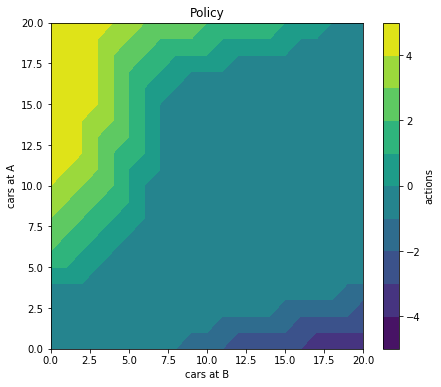

In [9]:
pol = np.argmax(Q_SA,axis=1) - 5
plot_policy(pol)

In [12]:
Q_SA.shape

(441, 11)

In [4]:
print(after1-after)

0:00:00.000032


In [29]:
Q_SA[(getValIndex(20,20))]

array([ 613.19819981,  618.35910849,  623.34867512,  628.14242854,
        632.69212575,  636.9257418 ,  634.25803633,  631.32404158,
        628.12420643,  624.66682595,  620.962967  ])

440